In [1]:
## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
from keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 0. 티커 입력

In [3]:
ticker = 'nvda'

# 1. Technical Analysis - LSTM model

In [4]:
## 1.1. Load data and Remove Missing value
df = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/{ticker}_stock_Tech_data.csv')
df.set_index('Date', inplace=True)

df = df.dropna()
df.isnull().sum() 

## 1.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# Create feature_df, label_df 
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transform
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2403, 17)
label_np.shape:(2403, 1)


In [5]:
## 1.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)

# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 


X.shape:(2373, 30, 17), Y.shape:(2373, 1)
x_train.shape:(1898, 30, 17), y_train.shape:(1898, 1)
x_test.shape:(475, 30, 17), y_test.shape:(475, 1)


In [6]:
## 1.4. Construct and Compile model
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=False, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
13/13 [==============================] - 2s 44ms/step - loss: 0.1207 - mae: 0.0419 - val_loss: 0.1466 - val_mae: 0.1596
Epoch 2/1000
13/13 [==============================] - 0s 23ms/step - loss: 0.0997 - mae: 0.0241 - val_loss: 0.0976 - val_mae: 0.0715
Epoch 3/1000
13/13

## 1.2. Technical model Accuracy test

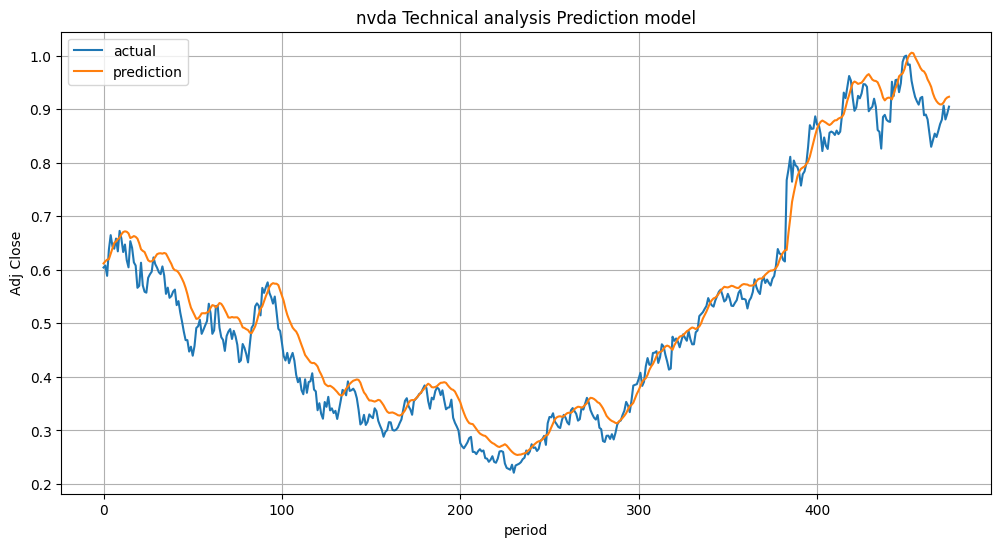

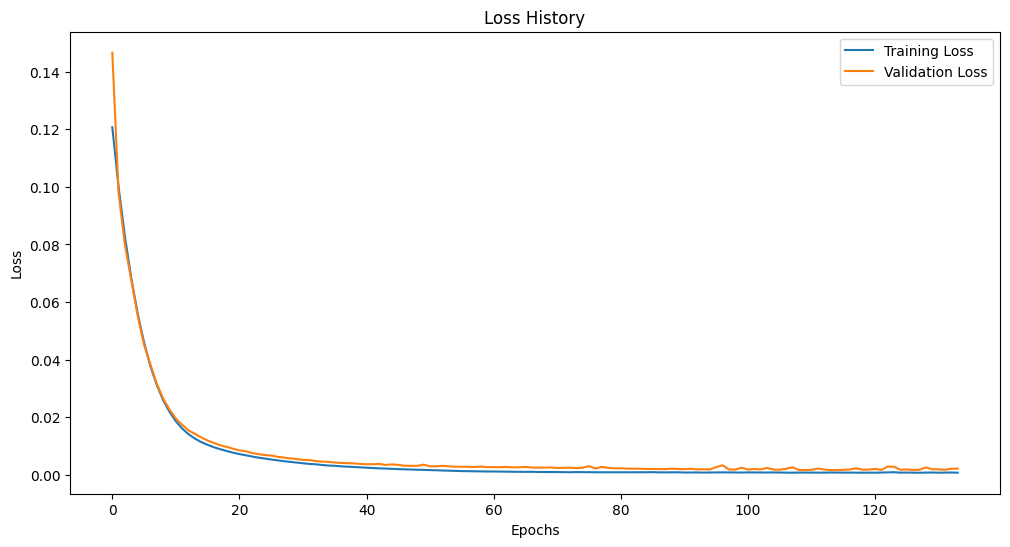

  Metrics    Values
0    MAPE  0.070468
1     MAE  0.031663
2    RMSE  0.040192


In [7]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Technical analysis Prediction model')
plt.ylabel('Adj Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()

# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation 2: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

## 1.3. DataFrame for use as input to the Stacking model

In [8]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 1.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [9]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3)  
else:
    next_day = last_date + pd.Timedelta(days=1)  

# 1. Extract the last 30 days data
recent_feature = feature_np[-window_size:]
recent_feature = recent_feature.reshape(1, window_size, -1)

# 2. Predict the value for the next day
predicted_new = model.predict(recent_feature)

# 3. Inverse transform the predicted value to its original scale
dummy_data = np.zeros((1, scaled_df.shape[1] - 1))
predicted_new_full_features = np.hstack([predicted_new, dummy_data])

tech_predicted_new_original = scaler.inverse_transform(predicted_new_full_features)[0, 0]

1/1 [==============================] - 0s 11ms/step


# 2. Fundamental Analysis - LSTM model

In [10]:
## 2.1. Load data
df = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/{ticker}_FS_summary.csv')
df2 = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/Econ_data.csv')
df3 = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/Industry_data.csv')

df.set_index('Date', inplace=True)
df2.set_index('Date', inplace=True)
df3.set_index('Date', inplace=True)

df = df.merge(df2, on='Date', how='left')
df = df.merge(df3, on='Date', how='left')

df = df.dropna()
df.isnull().sum() 

## 2.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# feature_df, label_df 생성
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transformation
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2502, 25)
label_np.shape:(2502, 1)


In [11]:
## 2.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)


# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 

X.shape:(2472, 30, 25), Y.shape:(2472, 1)
x_train.shape:(1977, 30, 25), y_train.shape:(1977, 1)
x_test.shape:(495, 30, 25), y_test.shape:(495, 1)


In [12]:
## 2.4. Construct and Compile model
model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape, return_sequences=True,
               kernel_regularizer=L1L2(l1=0.001, l2=0.001), recurrent_regularizer=L1L2(l1=0.001, l2=0.001)))
               
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           78848     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 128321 (501.25 KB)
Trainable params: 128321 (501.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
1

## 2.2. Fundamental model Accuracy test

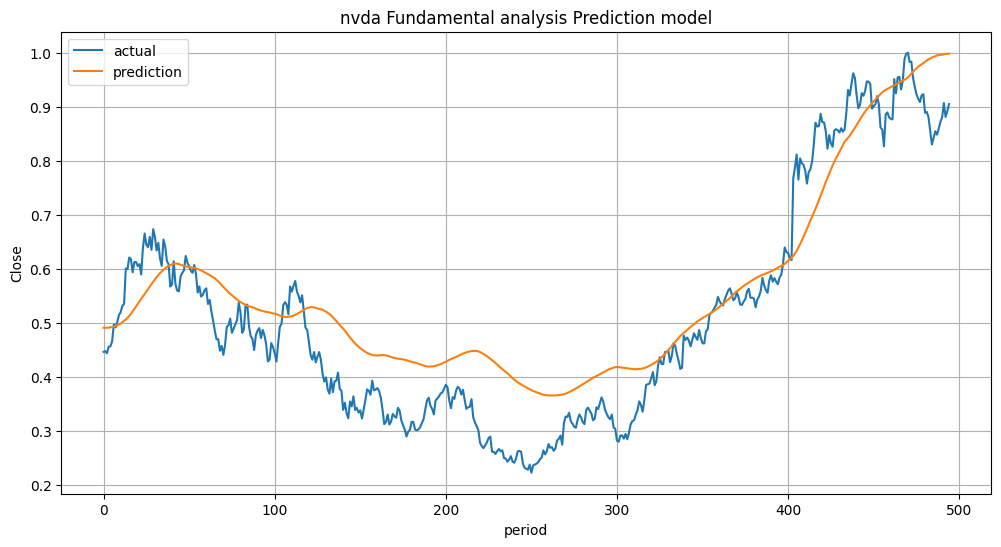

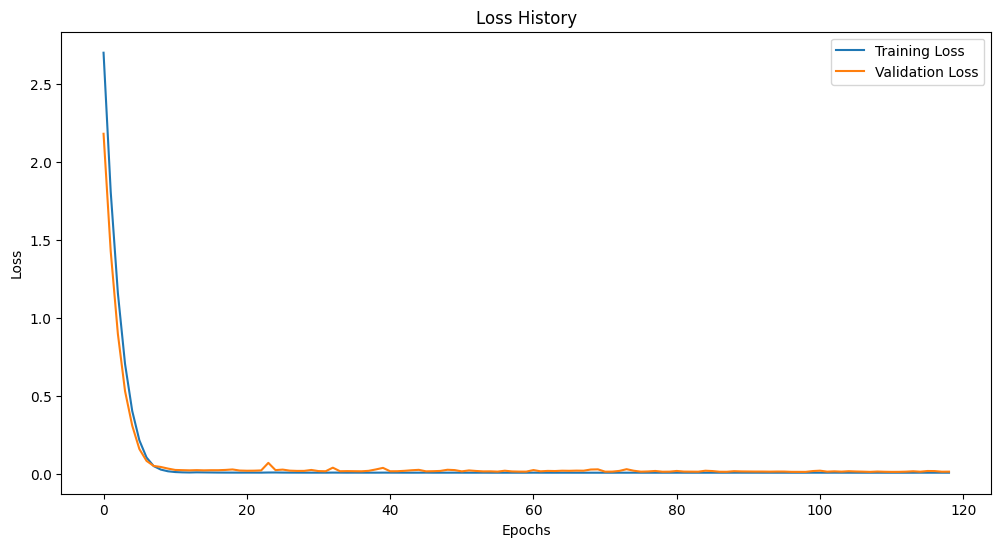

  Metrics    Values
0    MAPE  0.180943
1     MAE  0.070397
2    RMSE  0.084336


In [13]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Fundamental analysis Prediction model')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()


# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Evaluation 3: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

## 2.3. DataFrame for use as input to the Stacking model

In [14]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

fund_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 2.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [15]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1) 

# 1. Extract the last 50 days data
latest_data = feature_np[-window_size:]
latest_data = latest_data.reshape(1, window_size, -1)

# 2. Predict the value for the next day
next_day_pred = model.predict(latest_data)

# 3. Inverse transform the predicted value to its original scale
inverse_df_temp = pd.DataFrame(np.zeros((1, len(scale_cols))), columns=scale_cols)  
inverse_df_temp['Adj Close'] = next_day_pred.flatten()
fund_predicted_new_original = scaler.inverse_transform(inverse_df_temp)[:, inverse_df_temp.columns.get_loc('Adj Close')]

# Convert numpy array value to scalar
fund_predicted_new_original = fund_predicted_new_original.item()

1/1 [==============================] - 0s 25ms/step


# 3. 최종예측을 위한 Stacking model 생성 (XGBoost, GridSearchCV)

## 3.1. 데이터 준비 및 전처리

In [16]:
# 1. Create dataframe based on each analysis result
df = pd.merge(tech_result_df[['Date', 'Real Price', 'Predicted Price']], 
                     fund_result_df[['Date', 'Predicted Price']],
                     on='Date', 
                     how='inner', 
                     suffixes=('_Tech', '_Fund'))

df.columns = ['Date', 'Real Price', 'Tech_Pred', 'Fund_Pred'] # Rename Column
df = df.set_index('Date').sort_index()

# 2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = ['Real Price', 'Tech_Pred', 'Fund_Pred']
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Create Feature/Label for Stacking model
X_stack = scaled_df[['Tech_Pred', 'Fund_Pred']].values
y_stack = scaled_df['Real Price'].values

# 3. Data split (20% test)
X_train, X_val, y_train, y_val = train_test_split(X_stack, y_stack, test_size=0.2, random_state=42)

print(f'X_train.shape:{X_train.shape}, X_val.shape:{X_val.shape}')
print(f'y_train.shape:{y_train.shape}, y_val.shape:{y_val.shape}') 


X_train.shape:(380, 2), X_val.shape:(95, 2)
y_train.shape:(380,), y_val.shape:(95,)


In [17]:
# 4. Meta model training using XGBoost with GridSearchCV
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with best parameters
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
meta_model_xgb.fit(X_train, y_train)

y_pred = meta_model_xgb.predict(X_val)


Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.9}


## 3.2. Meta model result visualization

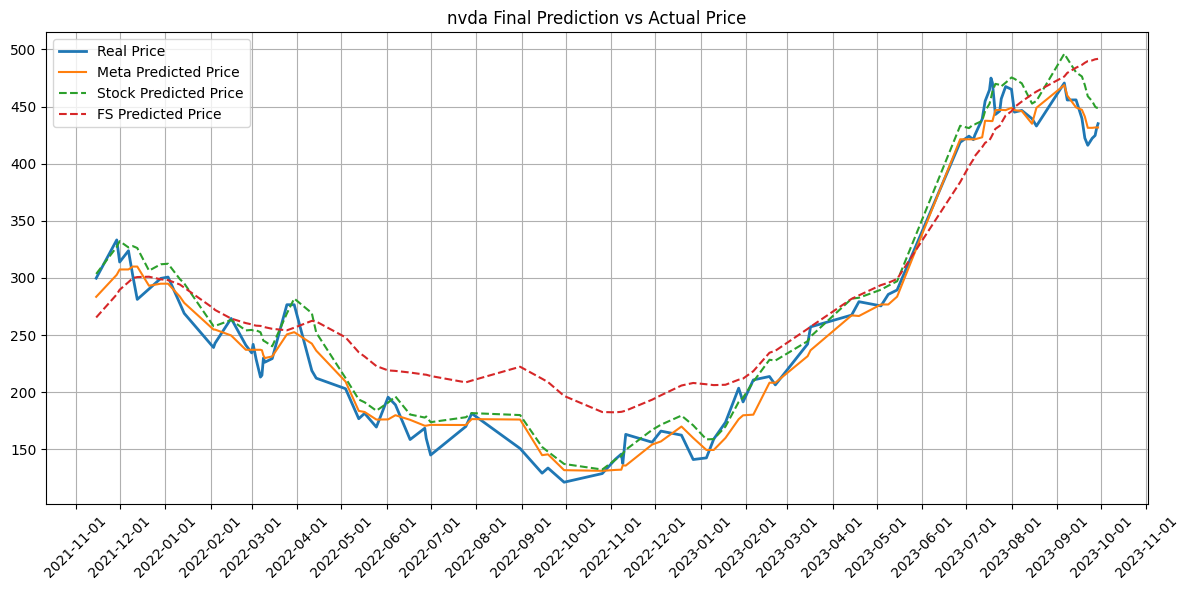

In [18]:
# Extracting predicted values from scaled data
y_val_original = scaler.inverse_transform(np.column_stack([y_val, np.zeros_like(y_val), np.zeros_like(y_val)]))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack([y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)]))[:, 0]
tech_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), X_val[:, 0], np.zeros_like(y_pred)]))[:, 1]
fund_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), np.zeros_like(y_pred), X_val[:, 1]]))[:, 2]

# Extracting date index
date_train, date_val = train_test_split(df.index, test_size=0.2, random_state=42)

# Prediction Graph
plot_df = pd.DataFrame({
    'Date': date_val,
    'Real Price': y_val_original,
    'Meta Predicted Price': y_pred_original,
    'Stock Predicted Price': tech_pred_original,
    'FS Predicted Price': fund_pred_original
})

plot_df = plot_df.sort_values(by='Date')
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Real Price'], label='Real Price', linewidth=2)
plt.plot(plot_df['Date'], plot_df['Meta Predicted Price'], label='Meta Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['Stock Predicted Price'], '--', label='Stock Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['FS Predicted Price'], '--', label='FS Predicted Price', linewidth=1.5)

ax = plt.gca() 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

plt.title(f"{ticker} Final Prediction vs Actual Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  


## 3.3. Meta model Accuracy Test

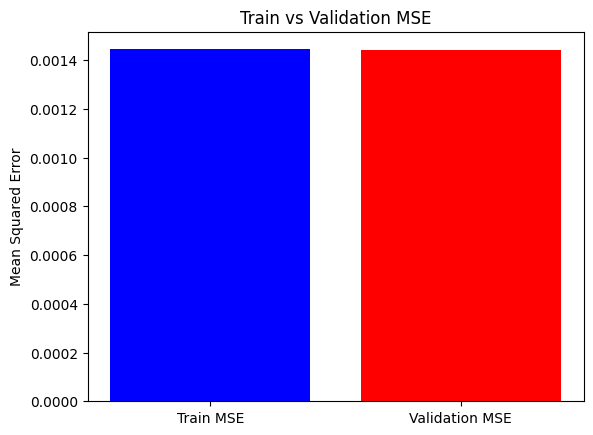

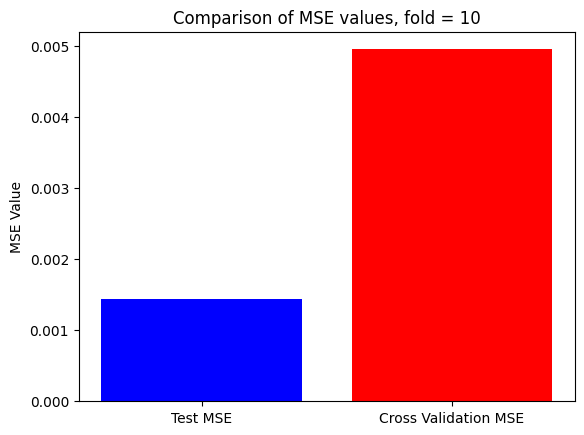

In [19]:
# 1. MSE Comparison Graph for train and validation set
y_train_pred = meta_model_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_pred)

plt.bar(['Train MSE', 'Validation MSE'], [train_mse, val_mse], color=['blue', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.show()

# 2.  MSE Comparison Graph using cross validation for validation and cv validation (fold =10)
cross_val_mse = -cross_val_score(meta_model_xgb, X_stack, y_stack, cv=10, scoring='neg_mean_squared_error').mean()
errors = [val_mse, cross_val_mse]
labels = ['Test MSE', 'Cross Validation MSE']

plt.bar(labels, errors, color=['blue', 'red'])
plt.ylabel('MSE Value')
plt.title('Comparison of MSE values, fold = 10')
plt.show()

## 3.4. Predicting the actual price for the next day

In [20]:
# Predicted values for the next day obtained from the Technical and Fundamental models
next_day_tech_pred = tech_predicted_new_original  
next_day_fund_pred = fund_predicted_new_original 

next_day_tech_pred_scaled = scaler.transform([[0, next_day_tech_pred, 0]])[0][1]  # 가격 부분만 스케일링
next_day_fund_pred_scaled = scaler.transform([[0, 0, next_day_fund_pred]])[0][2]  # 가격 부분만 스케일링

# Predict with trained stacking model
next_day_meta_pred_scaled = meta_model_xgb.predict(np.array([[next_day_tech_pred_scaled, next_day_fund_pred_scaled]]))[0]
next_day_meta_pred = scaler.inverse_transform([[next_day_meta_pred_scaled, 0, 0]])[0][0]

# Print the date of the next day
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4: 
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1)  

print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Tech 예측 가격은: {next_day_tech_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Funda 예측 가격은: {next_day_fund_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 최종 예측 가격은: {next_day_meta_pred}") 

다음 날(2023-10-06)의 Tech 예측 가격은: 465.64511745859636
다음 날(2023-10-06)의 Funda 예측 가격은: 492.5908551569859
다음 날(2023-10-06)의 최종 예측 가격은: 431.66301281838975


#### 여기서부턴 아님: 시뮬레이션 위한 히스토리 코드

In [21]:
# fund_result_df에서 'Real Price' 열 삭제
fund_result_df2 = fund_result_df.drop(columns='Real Price')

# 날짜를 기준으로 두 데이터프레임 합치기
merged_df = pd.merge(tech_result_df, fund_result_df2, on='Date', suffixes=('_tech', '_fund'))


# 스케일러와 메타 모델은 위에서 이미 정의했다고 가정하고, 계속 사용합니다.

def compute_next_day_prediction(row):
    # 현재 날짜의 예측값 가져오기
    current_day_tech_pred = row['Predicted Price_tech']
    current_day_fund_pred = row['Predicted Price_fund']

    # 스케일링
    current_day_tech_pred_scaled = scaler.transform([[0, current_day_tech_pred, 0]])[0][1]
    current_day_fund_pred_scaled = scaler.transform([[0, 0, current_day_fund_pred]])[0][2]

    # 스택킹 모델 예측
    next_day_meta_pred_scaled = meta_model_xgb.predict(np.array([[current_day_tech_pred_scaled, current_day_fund_pred_scaled]]))[0]
    next_day_meta_pred = scaler.inverse_transform([[next_day_meta_pred_scaled, 0, 0]])[0][0]

    return next_day_meta_pred

# 각 row에 대해서 다음 날 예측값 계산
merged_df['Tmr_Predicted'] = merged_df.apply(compute_next_day_prediction, axis=1)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)

save_path = f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/수익내자/결과용데이터/{ticker}_가지고놀기.csv'  
merged_df.to_csv(save_path, index=True) 



#### 실제 예측 시뮬레이션을 위한 데이터프레임 생성

In [22]:
df = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/dacon/final/Loaded data/{ticker}_stock_Tech_data.csv')
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

# 빈 데이터프레임 생성
prediction_df = pd.DataFrame(columns=['Date', 'Real Price', 'Tmr Tech Prediction', 'Tmr Fund Prediction', 'Tmr Meta Prediction', 'Accuracy'])

# last_date의 다음날 날짜 계산

last_date = pd.to_datetime(df.index[-1]) # df의 마지막 행의 날짜를 가져옴
next_date = last_date + pd.Timedelta(days=1)

# 해당 날짜가 이미 데이터프레임에 존재하는지 확인
if not (prediction_df['Date'] == last_date).any():
    
    # last_date에 해당하는 Real Price 값 가져오기
    real_price_value = df.loc[last_date, 'Adj Close']

    # 예측값들을 새로운 행으로 추가
    new_row = {
        'Date': last_date,
        'Real Price': real_price_value,
        'Tmr Tech Prediction': next_day_tech_pred,
        'Tmr Fund Prediction': next_day_fund_pred,
        'Tmr Meta Prediction': next_day_meta_pred,
    }

    prediction_df = prediction_df.append(new_row, ignore_index=True)
    
    # Accuracy 계산 후 추가
    prediction_df['Accuracy'] = (1 - (prediction_df['Real Price'].shift(-1) - prediction_df['Tmr Meta Prediction']).abs() / prediction_df['Real Price'].shift(-1)) * 100
else:
    print(f"{last_date}에 대한 예측값은 이미 데이터프레임에 존재합니다!")

print(prediction_df)


save_path = f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/수익내자/결과용데이터/{ticker}_실제.csv'  
prediction_df.to_csv(save_path, index=True) 


        Date  Real Price  Tmr Tech Prediction  Tmr Fund Prediction  Tmr Meta Prediction  Accuracy
0 2023-10-05  446.880005           465.645117           492.590855           431.663013       NaN


/var/folders/tg/zkyfgzc956x93vldnpdh1rvm0000gn/T/ipykernel_77789/2551016585.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_df = prediction_df.append(new_row, ignore_index=True)
